In [2]:
import pandas as pd
import numpy as np
import pydicom as dicom
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
data_path = Path('rsna-pneumonia-detection-challenge')

### Labels data

In [4]:
labels_path = data_path / 'stage_2_train_labels.csv'

In [5]:
labels = pd.read_csv(labels_path)

In [6]:
labels.shape

(30227, 6)

- Total records = 30227

In [7]:
labels.head(2)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0


- Total 6 columns
- 1 for id
- 4 for position of box
- 1 for Target variable

In [8]:
labels['patientId'].nunique()

26684

- Total patients = 26684
- A patient may have multiple records corresponding to each - area

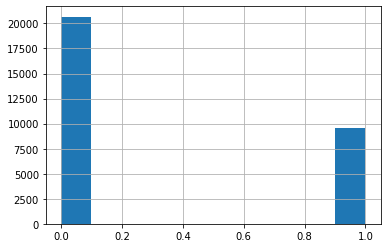

In [9]:
labels['Target'].hist();

In [10]:
np.bincount(labels['Target'])

array([20672,  9555])

- 0 (not infected) -- 20672
- 1 (infected)     -- 9555

### Class info

In [11]:
class_info_path = data_path / 'stage_2_detailed_class_info.csv'

In [12]:
class_info = pd.read_csv(class_info_path)

In [13]:
class_info.shape

(30227, 2)

In [14]:
class_info.head(2)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal


In [15]:
class_info['patientId'].nunique()

26684

### A patient may fall into any of the 3 categories:
#### label-1
- having Pneumonia, 

##### label-0
- not having Pneumonia and normal
- not having Pneumonia and not-normal/no-lung-opacity

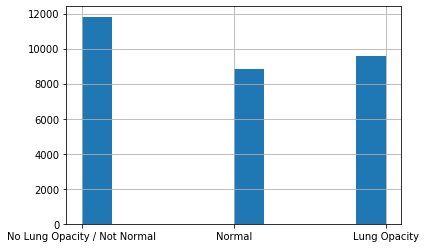

In [16]:
class_info['class'].hist();

- Not Normal ~ 12000
- Normal ~ 9000
- Lung Opacity ~ 9500

### Image data

In [16]:
images_path = data_path / 'stage_2_train_images'

In [49]:
n_patient = len(os.listdir(images_path))
n_patient

26684

In [18]:
filename = os.listdir(images_path)[0]

file = dicom.dcmread(images_path / filename)

In [19]:
file.dir()

['AccessionNumber',
 'BitsAllocated',
 'BitsStored',
 'BodyPartExamined',
 'Columns',
 'ConversionType',
 'HighBit',
 'InstanceNumber',
 'LossyImageCompression',
 'LossyImageCompressionMethod',
 'Modality',
 'PatientAge',
 'PatientBirthDate',
 'PatientID',
 'PatientName',
 'PatientOrientation',
 'PatientSex',
 'PhotometricInterpretation',
 'PixelData',
 'PixelRepresentation',
 'PixelSpacing',
 'ReferringPhysicianName',
 'Rows',
 'SOPClassUID',
 'SOPInstanceUID',
 'SamplesPerPixel',
 'SeriesDescription',
 'SeriesInstanceUID',
 'SeriesNumber',
 'SpecificCharacterSet',
 'StudyDate',
 'StudyID',
 'StudyInstanceUID',
 'StudyTime',
 'ViewPosition']

In [20]:
from concurrent.futures import ProcessPoolExecutor

In [21]:
def get_age_gender(filename):
    file = dicom.dcmread(images_path / filename)
    return (file.PatientAge, file.PatientSex)

In [22]:
with ProcessPoolExecutor() as executor:
    a = list(executor.map(get_age_gender, os.listdir(images_path)))

In [23]:
age_gender = pd.DataFrame(a, columns=['age', 'gender'])

In [24]:
age_gender.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26684 entries, 0 to 26683
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     26684 non-null  object
 1   gender  26684 non-null  object
dtypes: object(2)
memory usage: 417.1+ KB


In [25]:
age_gender['age'] = age_gender['age'].astype('int8')

In [26]:
age_gender.describe().T

,count,mean,std,min,25%,50%,75%,max
age,26684.0,46.982049,16.877806,-108.0,34.0,49.0,59.0,92.0


In [27]:
(age_gender['age']<0).sum()

5

- 5 negative

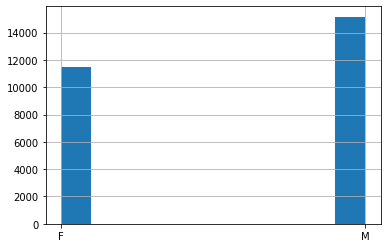

In [28]:
age_gender.gender.hist();

In [30]:
from matplotlib.patches import Rectangle

In [161]:
def plot_image(filename):
    file = dicom.dcmread(images_path / filename)
    id = filename.split('.')[0]
    records = labels[labels['patientId']==id]
    fig, ax = plt.subplots(1)
    
    if (len(records)==1 and records['Target'].values[0]==0):
        has_pneumonia = False
    else:
        has_pneumonia = True

    if has_pneumonia:
        for i, s in records.iloc[:, 1:5].iterrows():
            bbox = Rectangle((s['x'], s['y']), s['width'], s['height'], color='blue',
                             fill=False)
            ax.add_patch(bbox)
        ax.imshow(file.pixel_array, cmap='gray')
    else:
        ax.imshow(file.pixel_array, cmap='gray')

    c = class_info[class_info['patientId'] == id]['class'].values[0]
    ax.set_xlabel(c)

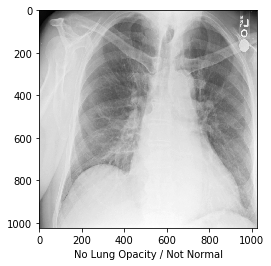

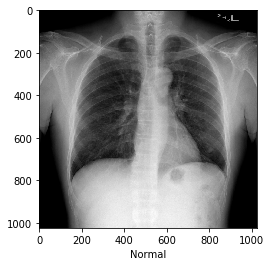

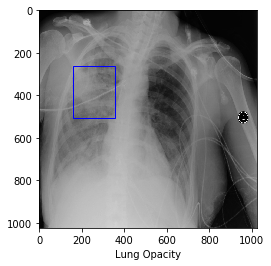

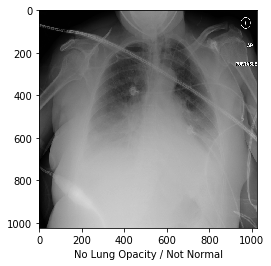

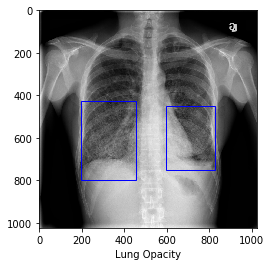

In [160]:
# ploting 5 random scans
for _ in range(5):
    n = np.random.randint(n_patient)
    filename = os.listdir(images_path)[n]
    plot_image(filename)